# Modello SIR

Vogliamo simulare un processo stocastico continuo a tre componenti $(S(t),I(t), R(t))$, dove $S,I,R$ rappresentano ad ogni istante le persone di una popolazione che sono, rispettivamente: infettabili (_susceptibles_), infette (_infected_) e guarite (_recovered_).

L'evoluzione approssima quella data da alcune equazioni differenziali
$$
\begin{cases}
    \frac{d}{dt}S = -\beta S I - \mu_{SR}N +\nu N & \\
    \frac{d}{dt}I = \beta S I -\mu_I N - \gamma I & \\
    \frac{d}{dt}R = \gamma I - \mu_{SR}N
\end{cases}
$$

dove
- $\beta$ è il tasso di contagio
- $\gamma$ è il tasso di guarigione
- $\mu_{SR}, \mu_{I}$ sono i tassi di decessi per persone sane e per infetti, rispettivamente
- $\nu$ è il tasso di nascita, normalmente si cancella con quello di morte.

In [2]:
from random import uniform
import numpy as np
import matplotlib.pyplot as plt

## Inizializzazione dei parametri

In [6]:
N=1002252      # Popolazione iniziale
I=3         # Persone infette inzialmente
R=0         # Guariti (Recovered)
S=N-I-R     # Infettabili (Susceptible)

beta=0.6671291         # Tasso di Infezione
gamma=0.3328710           # Tasso di Guarigione
mu_SR=0.01             # Tasso di morte/nascita per individui sani
mu_I=0.05               # Tasso di morte per individui infetti

T=70       # Orizzonte Temporale
t=0         # Tempo attuale
  

data=[]

x=[S,I,R]           # Parametri iniziali
rates=(beta, gamma, mu_SR, mu_I) # Parametri standard

### Simulazione di un salto del processo
La funzione a partire dalla variabile ```state``` genera un salto del processo. 
Innanzitutto considera il tempo che impiega a cambiare di stato ```jump_time``` secondo distribuzione esponenziale $\mathcal{E}(\mbox{total rate})$.
Dopodichè determina quale dei salti è avvenuto tra i possibili.

In [7]:
def SIR_onestep(state, parameters):
    S,I,R = state
    beta, gamma, mu_SR, mu_I = parameters
    total_pop = S + I + R
    rates_list = [S*mu_SR, R*mu_SR, I*mu_I, mu_SR*total_pop, beta*S*I/total_pop, gamma*I]
    cum_rates_list = np.concat(([0], np.cumsum(rates_list)))
    state_change = [[-1,0,0], [0,0,-1], [0,-1,0], [1, 0, 0], [-1, 1, 0], [0,-1, 1]]

    total_rate = sum(rates_list)
    if total_rate == 0:
        return [0,0,0,0.1]
    u = uniform(0,1)
    jump_time = -np.log(u)/total_rate

    random_rate = uniform(0,1)*total_rate
    for i in range(len(cum_rates_list)-1):
        if cum_rates_list[i] <=random_rate <= cum_rates_list[i+1]:
            return state_change[i] + [jump_time]

### Simulazione di una traiettoria

La funzione successiva simula una traiettoria a partire da ```initial state``` fino a ```max time``` utilizzando i parametri dati.

In [8]:
def SIR_trajectory(initial_state, max_time, parameters):
    times = [0]
    S_list = [initial_state[0]]
    I_list = [initial_state[1]]
    R_list = [initial_state[2]]
    total_infected_list = [0]
    while times[-1] < max_time:
        dS, dI, dR, jump_time = SIR_onestep([S_list[-1], I_list[-1], R_list[-1]], parameters)
        S_list.append(S_list[-1] + dS)
        I_list.append(I_list[-1] + dI)
        R_list.append(R_list[-1] + dR)
        times.append(times[-1]+jump_time)
        total_infected_list.append(total_infected_list[-1])
        if dI> 0:
            total_infected_list[-1] += dI
    return S_list, I_list, R_list, times, total_infected_list

### Grafico dei risultati

In [96]:
def plot_SIR(initial_state, max_time, parameters):
    Ss, Is, Rs, simulation_times, total_infected = SIR_trajectory(initial_state,max_time, parameters)
    
    plt.plot(simulation_times, Ss)
    plt.plot(simulation_times, Is)
    plt.plot(simulation_times, Rs)
    plt.plot(simulation_times, total_infected)
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend(['S','I','R','Total'],shadow=True)
    plt.title('SIR-Sim')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


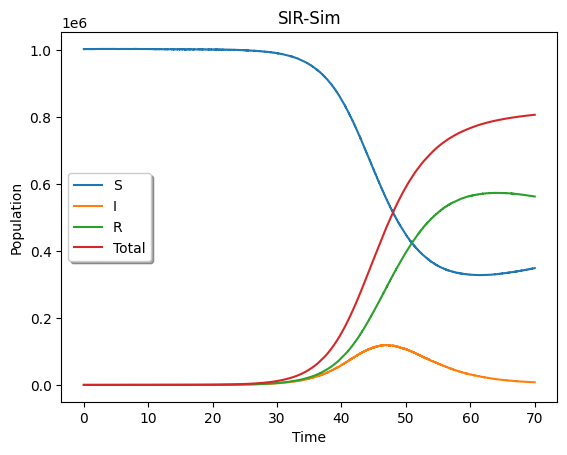

In [97]:
plot_SIR([S,I,R],T, rates)

In [102]:
Proava

NameError: name 'Proava' is not defined

### Confronto tra diverse traiettorie

In [98]:
def SIR_trajectories(n_sims, initial_state, parameters, max_time):
    for i in range(n_sims):
        Ss, Is, Rs, simulation_times, _ = SIR_trajectory(initial_state,max_time, parameters)
        plt.plot(simulation_times, Is)
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Infected people')

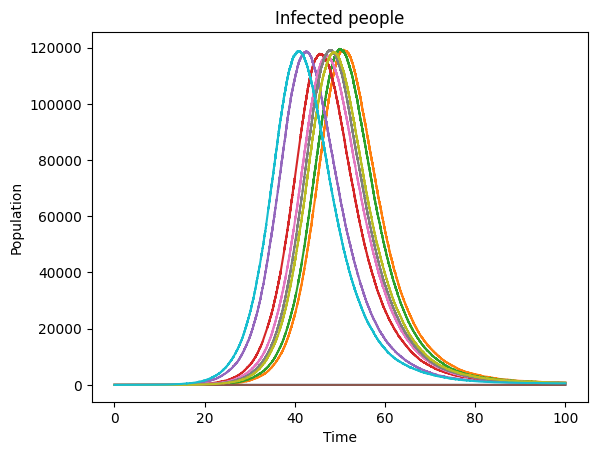

In [99]:
SIR_trajectories(10, [S,I,R], rates, 100)

### Utilizzo di $R_0$

Definiamo come $R_0$, tasso base di riproduzione, il rapporto $\frac{\beta}{\gamma}$. Esso rappresenta essenzialmente il numero di individui che una persona infetta contagia prima di guarire

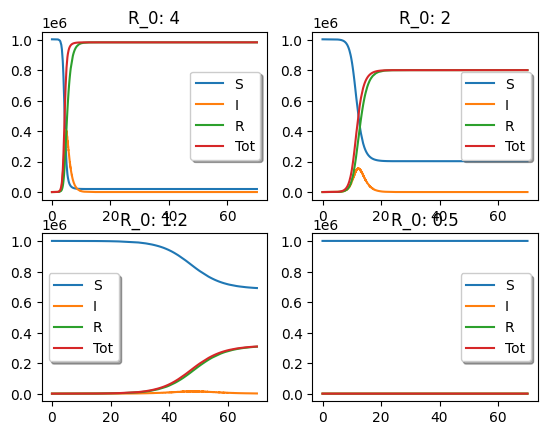

In [101]:
R_0 = [4, 2, 1.2, 0.5]
fig,ax = plt.subplots(2,2)

for i,r_0 in enumerate(R_0):
    parameters = [r_0, 1, 0, 0]
    Ss, Is, Rs, simulation_times, total_infected_people = SIR_trajectory([S,I,R],70, parameters)
    
    ax[i//2, i%2].plot(simulation_times, Ss)
    ax[i//2, i%2].plot(simulation_times, Is)
    ax[i//2, i%2].plot(simulation_times, Rs)
    ax[i//2, i%2].plot(simulation_times, total_infected_people)
    ax[i//2, i%2].legend(['S','I','R','Tot'],shadow=True)
    ax[i//2, i%2].set_title(f'R_0: {r_0}')

### Inserimento dei vaccini

L'inserimento dei vaccini può essere rappresentato da un maggior numero di persone guarite. A seconda dei parametri della malattia si può notare quanti vaccinati servano per avere immunità di gregge.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


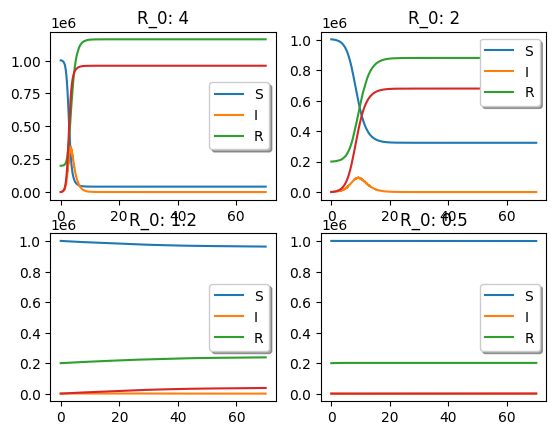

In [11]:
R_0 = [4, 2, 1.2, 0.5]
fig,ax = plt.subplots(2,2)

for i,r_0 in enumerate(R_0):
    parameters = [r_0, 1, 0, 0]
    Ss, Is, Rs, simulation_times, total_infected_people = SIR_trajectory([S,1000,200000],70, parameters)
    
    ax[i//2, i%2].plot(simulation_times, Ss)
    ax[i//2, i%2].plot(simulation_times, Is)
    ax[i//2, i%2].plot(simulation_times, Rs)
    ax[i//2, i%2].plot(simulation_times, total_infected_people)
    ax[i//2, i%2].legend(['S','I','R'],shadow=True)
    ax[i//2, i%2].set_title(f'R_0: {r_0}')